In [ ]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import gc
import calendar
import time
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Data Collection & Data Processing

In [ ]:
DATA_DIR = "/kaggle/input/telecom-italia-milan/data" #'./data'
txt_files = [file for file in os.listdir(DATA_DIR) if file.endswith('.txt')]
txt_files.sort()

columns =  ['CellId', 'datetime', 'countrycode', 'smsin', 'smsout', 'callin', 'callout', 'internet']

dtypes = {0: np.int16}

def read_one(file):
    """
    read the file in the DATA_DIR directory and build a dataframe

    Args: file name

    Returns: a dataframe
    """
    data = pd.read_csv(f'{DATA_DIR}/{file}', sep='\t', header=None, names=columns, dtype=dtypes)
    # for the homework we only need internet, it also helps optimize the memory usage
    data.drop(columns=['smsin', 'smsout', 'callin', 'callout'], inplace=True)
    data['datetime'] = pd.to_datetime(data['datetime'], unit='ms')
    data.dropna(subset=['internet'], inplace=True)
    return data


df = read_one(txt_files[0])
for file in tqdm(txt_files[1:]):
    df = pd.concat([df,  read_one(file)])
    gc.collect()

df.sort_values('datetime', inplace=True)

print('Memory Usage:', df.memory_usage(deep=True).sum() / 1024**3, 'GB')


100%|██████████| 61/61 [10:12<00:00, 10.05s/it]


Memory Usage: 5.087969794869423 GB


In [ ]:
df

,CellId,datetime,countrycode,internet
1,1,2013-10-31 23:00:00,39,11.028366
2939633,6446,2013-10-31 23:00:00,39,198.768401
1241312,3626,2013-10-31 23:00:00,46,0.186742
1241311,3626,2013-10-31 23:00:00,39,37.752544
1241310,3626,2013-10-31 23:00:00,32,0.183081
...,...,...,...,...
1437645,3858,2014-01-01 22:50:00,39,185.911208
302438,1645,2014-01-01 22:50:00,39,5.079692
1438691,3859,2014-01-01 22:50:00,32,0.047638
1435670,3856,2014-01-01 22:50:00,39,242.468087


In [ ]:
df_cdrs_nov = df[['datetime', 'CellId', 'internet', 'countrycode']].groupby(['datetime', 'CellId','countrycode'], as_index=False).sum()

In [ ]:
df_cdrs_nov

,datetime,CellId,countrycode,internet
0,2013-10-31 23:00:00,1,39,11.028366
1,2013-10-31 23:00:00,2,39,11.058225
2,2013-10-31 23:00:00,3,39,11.090008
3,2013-10-31 23:00:00,4,39,10.941881
4,2013-10-31 23:00:00,5,39,9.916548
...,...,...,...,...
160681347,2014-01-01 22:50:00,9996,39,24.024474
160681348,2014-01-01 22:50:00,9997,39,28.432498
160681349,2014-01-01 22:50:00,9998,39,27.588855
160681350,2014-01-01 22:50:00,9999,39,13.823244


In [ ]:
df_cdrs_nov.isnull().sum()#Checking null values

datetime       0
CellId         0
countrycode    0
internet       0
dtype: int64

In [ ]:
df_zero= df_cdrs_nov[df_cdrs_nov['internet']==0]
df_zero

,datetime,CellId,countrycode,internet


# Filter only data from CellId = 5161
# Then divide Datetime into Month and Time

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_cell = df_cdrs_nov[df_cdrs_nov['CellId'] == 5161].copy()
df_cell['datetime'] = pd.to_datetime(df_cell['datetime'])
df_cell['month'] = df_cell['datetime'].dt.month
df_cell['time'] = df_cell['datetime'].dt.time

df_cell

,datetime,CellId,countrycode,internet,month,time
7848,2013-10-31 23:00:00,5161,33,0.288616,10,23:00:00
7849,2013-10-31 23:00:00,5161,39,374.286303,10,23:00:00
7850,2013-10-31 23:00:00,5161,44,5.398009,10,23:00:00
23262,2013-10-31 23:10:00,5161,39,365.309544,10,23:10:00
23263,2013-10-31 23:10:00,5161,43,0.201350,10,23:10:00
...,...,...,...,...,...,...
160675036,2014-01-01 22:50:00,5161,7,0.617756,1,22:50:00
160675037,2014-01-01 22:50:00,5161,39,135.760869,1,22:50:00
160675038,2014-01-01 22:50:00,5161,41,2.749999,1,22:50:00
160675039,2014-01-01 22:50:00,5161,49,5.875881,1,22:50:00


# Check difference between Time is 10 minutes

In [ ]:
df_cell['time_diff'] = df_cell['datetime'].diff()

# Filter where time difference is NOT 10 minutes or 0
invalid_rows = df_cell[~df_cell['time_diff'].isin([pd.Timedelta(minutes=10), pd.Timedelta(0)])]

# Show time (not full datetime) and difference
invalid_rows['time'] = df_cell['datetime'].dt.time

print(invalid_rows[['datetime', 'time', 'time_diff']])


                datetime      time time_diff
7848 2013-10-31 23:00:00  23:00:00       NaT


/tmp/ipykernel_35/4060263281.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invalid_rows['time'] = df_cell['datetime'].dt.time


# Remove outliers using IQR

In [ ]:

def remove_outliers(group):
    Q1 = group['internet'].quantile(0.25)
    Q3 = group['internet'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return group[(group['internet'] >= lower) & (group['internet'] <= upper)]

df_cell_clean = df_cell.groupby(['datetime'], group_keys=False).apply(remove_outliers)

df_cell_clean

/tmp/ipykernel_35/106971019.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cell_clean = df_cell.groupby(['datetime'], group_keys=False).apply(remove_outliers)


,datetime,CellId,countrycode,internet,month,time,time_diff
7848,2013-10-31 23:00:00,5161,33,0.288616,10,23:00:00,NaT
7849,2013-10-31 23:00:00,5161,39,374.286303,10,23:00:00,0 days 00:00:00
7850,2013-10-31 23:00:00,5161,44,5.398009,10,23:00:00,0 days 00:00:00
23263,2013-10-31 23:10:00,5161,43,0.201350,10,23:10:00,0 days 00:00:00
23264,2013-10-31 23:10:00,5161,57,5.587124,10,23:10:00,0 days 00:00:00
...,...,...,...,...,...,...,...
160661484,2014-01-01 22:40:00,5161,974,0.087267,1,22:40:00,0 days 00:00:00
160675036,2014-01-01 22:50:00,5161,7,0.617756,1,22:50:00,0 days 00:10:00
160675038,2014-01-01 22:50:00,5161,41,2.749999,1,22:50:00,0 days 00:00:00
160675039,2014-01-01 22:50:00,5161,49,5.875881,1,22:50:00,0 days 00:00:00


# Interpolate missing values using average at same time & month

In [ ]:
avg_usage = df_cell_clean.groupby(['month', 'time'])['internet'].mean().reset_index()
avg_usage.rename(columns={'internet': 'internet_avg'}, inplace=True)

df_cell_clean = df_cell_clean.merge(avg_usage, on=['month', 'time'], how='left')
df_cell_clean['internet'] = df_cell_clean['internet'].fillna(df_cell_clean['internet_avg'])
df_cell_clean.drop(columns=['internet_avg','time_diff'], inplace=True)
df_cell_clean

,datetime,CellId,countrycode,internet,month,time
0,2013-10-31 23:00:00,5161,33,0.288616,10,23:00:00
1,2013-10-31 23:00:00,5161,39,374.286303,10,23:00:00
2,2013-10-31 23:00:00,5161,44,5.398009,10,23:00:00
3,2013-10-31 23:10:00,5161,43,0.201350,10,23:10:00
4,2013-10-31 23:10:00,5161,57,5.587124,10,23:10:00
...,...,...,...,...,...,...
64552,2014-01-01 22:40:00,5161,974,0.087267,1,22:40:00
64553,2014-01-01 22:50:00,5161,7,0.617756,1,22:50:00
64554,2014-01-01 22:50:00,5161,41,2.749999,1,22:50:00
64555,2014-01-01 22:50:00,5161,49,5.875881,1,22:50:00


# Check if Data is stationary or not

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary, consider differencing")

# Check stationarity
check_stationarity(df_cell_clean['internet'])


ADF Statistic: -20.875483361114615
p-value: 0.0
Series is stationary


# Resample Data from 10 minutes to Hourly

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert datetime and set as index
df_cell_clean['datetime'] = pd.to_datetime(df_cell_clean['datetime'])
df_cell_clean.set_index('datetime', inplace=True)

# Aggregate data to 10-minute intervals and resample to hourly
hourly_data = df_cell_clean['internet'].resample('h').mean()

# Fill missing values
hourly_data.fillna(hourly_data.mean(), inplace=True)
hourly_data

datetime
2013-10-31 23:00:00     52.355331
2013-11-01 00:00:00     50.903551
2013-11-01 01:00:00    114.652091
2013-11-01 02:00:00     81.436053
2013-11-01 03:00:00     60.111537
                          ...    
2014-01-01 18:00:00      1.539103
2014-01-01 19:00:00      1.589050
2014-01-01 20:00:00      0.799199
2014-01-01 21:00:00      0.323985
2014-01-01 22:00:00      1.073782
Freq: h, Name: internet, Length: 1488, dtype: float64

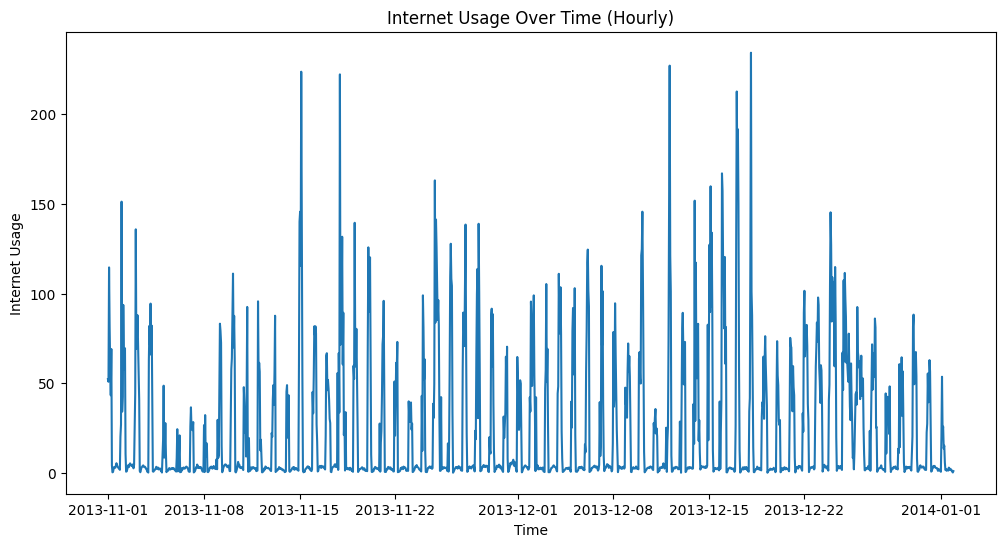

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(hourly_data)
plt.title('Internet Usage Over Time (Hourly)')
plt.xlabel('Time')
plt.ylabel('Internet Usage')
plt.show()

# Time Series Decomposition on hourly data

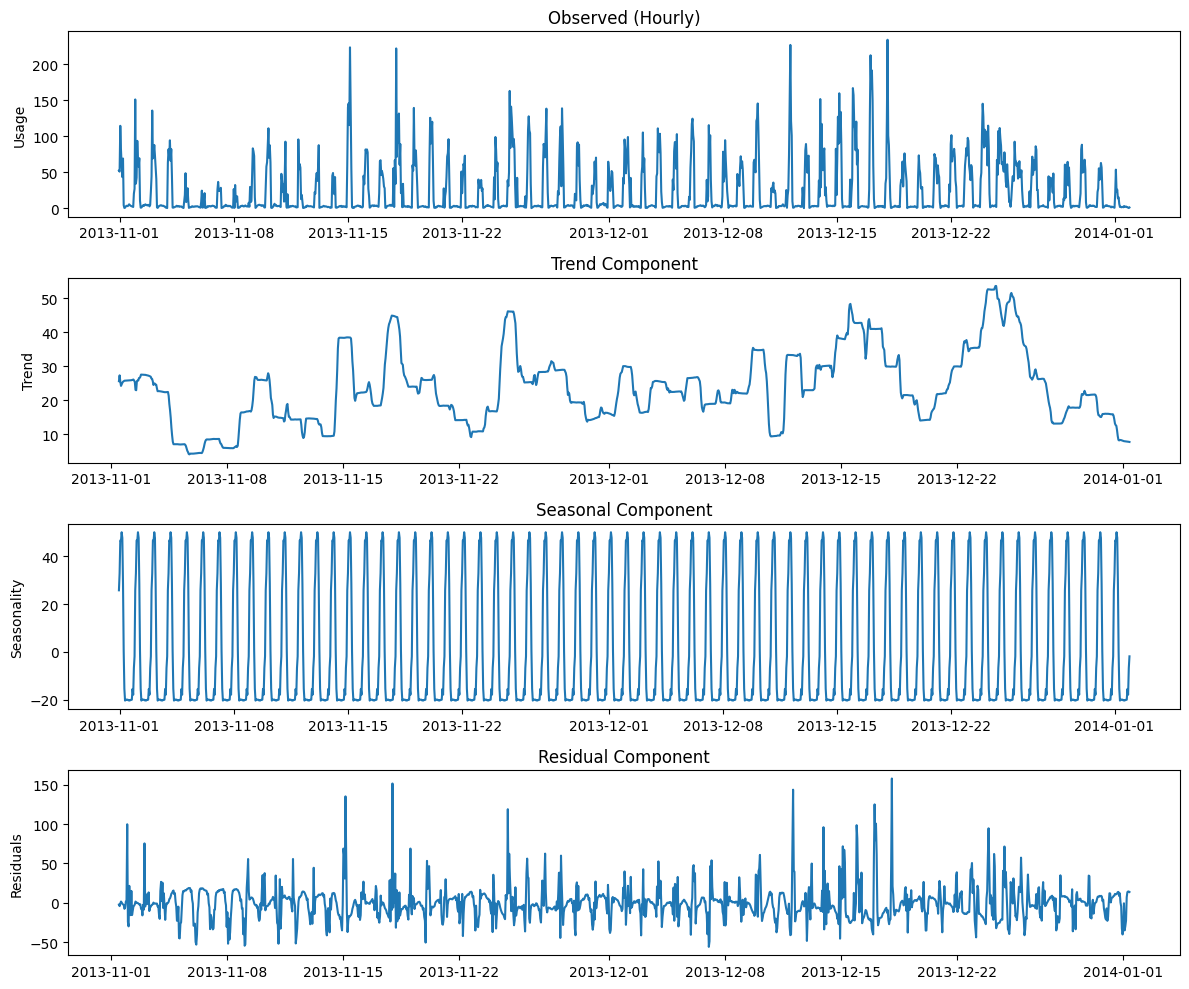

In [ ]:
result_hourly = seasonal_decompose(hourly_data, model='additive', period=24)  # 24 hours = daily

plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(result_hourly.observed)
plt.title('Observed (Hourly)')
plt.ylabel('Usage')

plt.subplot(4, 1, 2)
plt.plot(result_hourly.trend)
plt.title('Trend Component')
plt.ylabel('Trend')

plt.subplot(4, 1, 3)
plt.plot(result_hourly.seasonal)
plt.title('Seasonal Component')
plt.ylabel('Seasonality')

plt.subplot(4, 1, 4)
plt.plot(result_hourly.resid)
plt.title('Residual Component')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Decompose daily data with WEEKLY seasonality

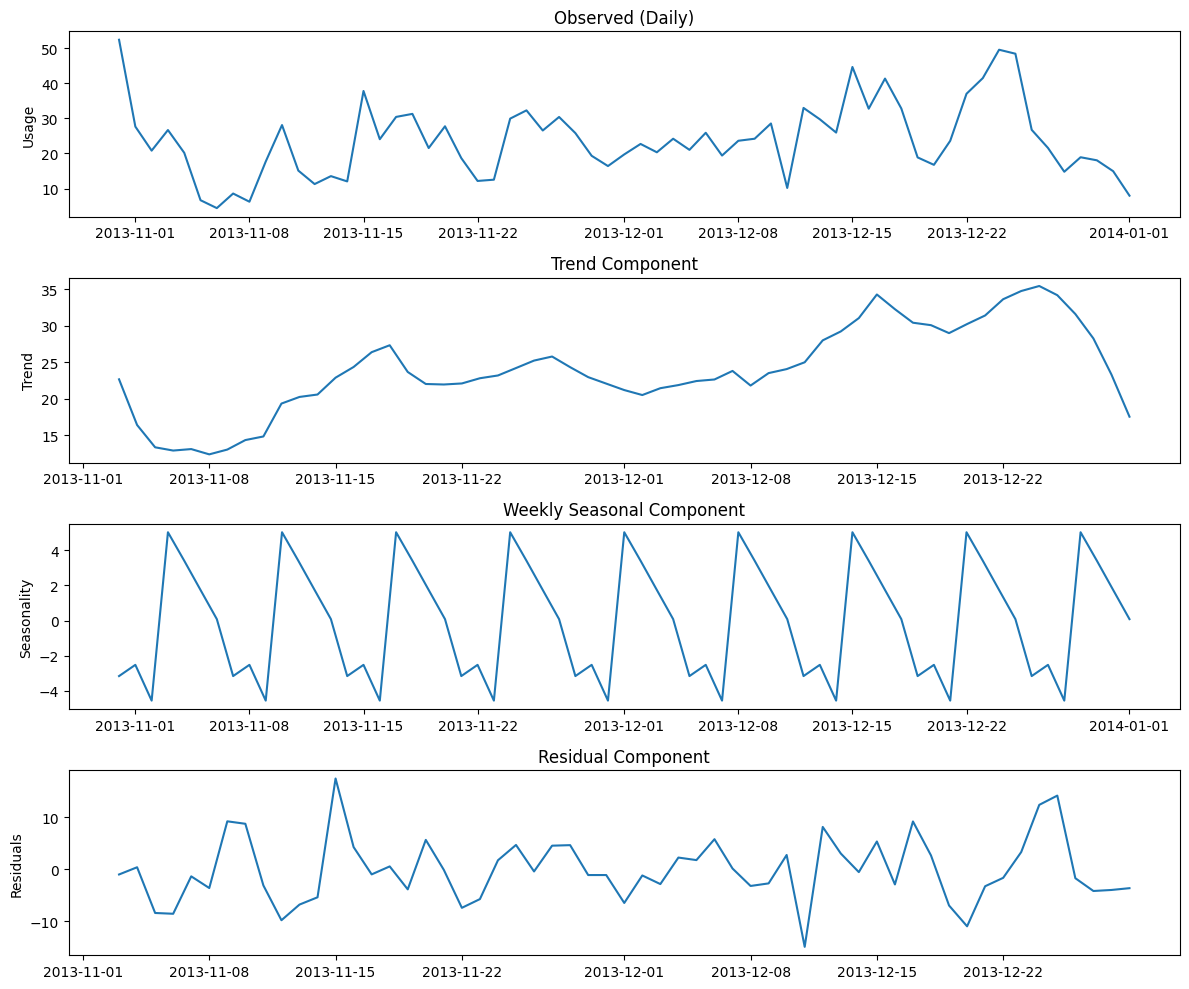

In [ ]:
daily_data = hourly_data.resample('D').mean()
daily_data.fillna(daily_data.mean(), inplace=True)

# Decompose daily data with WEEKLY seasonality (7-day period)
result_daily = seasonal_decompose(daily_data, model='additive', period=7)  # Weekly seasonality

plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(result_daily.observed)
plt.title('Observed (Daily)')
plt.ylabel('Usage')

plt.subplot(4, 1, 2)
plt.plot(result_daily.trend)
plt.title('Trend Component')
plt.ylabel('Trend')

plt.subplot(4, 1, 3)
plt.plot(result_daily.seasonal)
plt.title('Weekly Seasonal Component')
plt.ylabel('Seasonality')

plt.subplot(4, 1, 4)
plt.plot(result_daily.resid)
plt.title('Residual Component')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# plot stationary & non stationary

In [ ]:
non_stationary = daily_data
stationary = daily_data.diff().dropna()

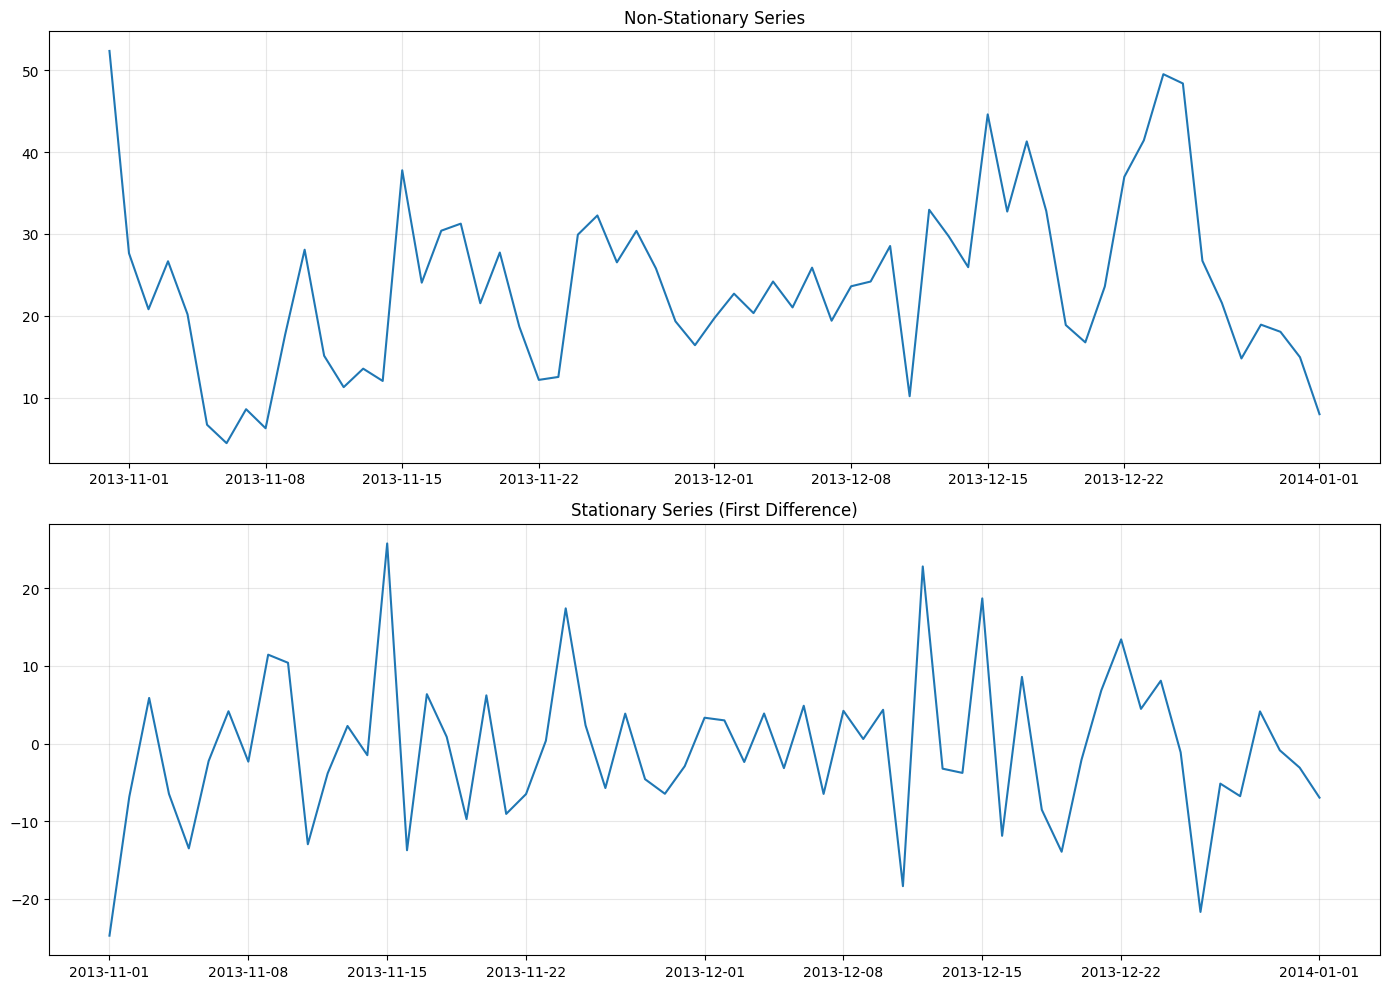

In [ ]:
plt.figure(figsize=(14, 10))
plt.subplot(211)
plt.plot(non_stationary)
plt.title('Non-Stationary Series')
plt.grid(True, alpha=0.3)

plt.subplot(212)
plt.plot(stationary)
plt.title('Stationary Series (First Difference)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot Autocorrelation function & Partial Autocorrelation function

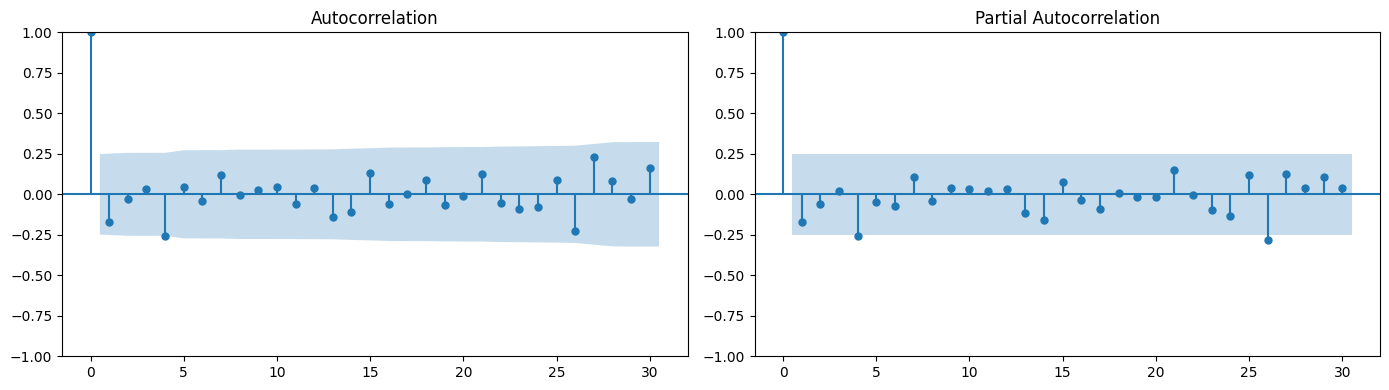

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Get the maximum allowed lags (50% of sample size)
max_lags = len(stationary) // 2 - 1  # Using floor division for safety

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(stationary, lags=max_lags, ax=axes[0])
plot_pacf(stationary, lags=max_lags, ax=axes[1])
plt.tight_layout()
plt.show()

# Split Data into 80% for trainning and 20% for testing

In [ ]:
total_hours = len(hourly_data)  # 1488 hours
train_size = int(total_hours * 0.8)  # 1190 hours for training


In [ ]:
train_hourly = hourly_data.iloc[:train_size]
train_hourly

datetime
2013-10-31 23:00:00     52.355331
2013-11-01 00:00:00     50.903551
2013-11-01 01:00:00    114.652091
2013-11-01 02:00:00     81.436053
2013-11-01 03:00:00     60.111537
                          ...    
2013-12-20 08:00:00      1.583995
2013-12-20 09:00:00      2.744524
2013-12-20 10:00:00      1.785485
2013-12-20 11:00:00      1.743975
2013-12-20 12:00:00      2.823079
Freq: h, Name: internet, Length: 1190, dtype: float64

In [ ]:

test_hourly = hourly_data.iloc[train_size:]

test_hourly

datetime
2013-12-20 13:00:00    3.238139
2013-12-20 14:00:00    2.768729
2013-12-20 15:00:00    2.063111
2013-12-20 16:00:00    2.890434
2013-12-20 17:00:00    2.473424
                         ...   
2014-01-01 18:00:00    1.539103
2014-01-01 19:00:00    1.589050
2014-01-01 20:00:00    0.799199
2014-01-01 21:00:00    0.323985
2014-01-01 22:00:00    1.073782
Freq: h, Name: internet, Length: 298, dtype: float64

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Building SARIMA using Grid Search

In [ ]:
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 3)
D = range(0, 2)
Q = range(0, 3)
m = 24  # Seasonal period

#Create all combinations of p, d, and q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

best_aic = float("inf")
best_order = None
best_seasonal_order = None
#Loops through each combination of pdq and seasonal_pdq
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train_hourly, order=param, seasonal_order=param_seasonal + (m,), enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
        except:
            continue

print("Best SARIMAX model: {} x {} with AIC={}".format(best_order, best_seasonal_order + (m,), best_aic))


best_mod = SARIMAX(train_hourly, order=best_order, seasonal_order=best_seasonal_order + (m,), enforce_stationarity=False, enforce_invertibility=False)
best_results = best_mod.fit(disp=False)

train_fitted = best_results.fittedvalues
mae_train = mean_absolute_error(train_hourly, train_fitted)
mape_train = mean_absolute_percentage_error(train_hourly, train_fitted)
print(f"Train MAE: {mae_train}")
print(f"Train MAPE: {mape_train}")

forecast = best_results.forecast(steps=test_size)
mae_test = mean_absolute_error(test_hourly, forecast)
mape_test = mean_absolute_percentage_error(test_hourly, forecast)
print(f"Test MAE: {mae_test}")
print(f"Test MAPE: {mape_test}")

Best SARIMAX model: (2, 1, 2) x (1, 1, 2, 24) with AIC=9972.262925880143
Train MAE: 12.135793649164306
Train MAPE: 3.2034447631480147
Test MAE: 18.139685190609995
Test MAPE: 3.312119033222532
